In [1]:
import subprocess
import neutralb1.utils

WORKSPACE_DIR = neutralb1.utils.get_workspace_dir()

git_hash = subprocess.check_output(['git', 'rev-parse', 'HEAD'], cwd=WORKSPACE_DIR).decode('utf-8').strip()
print(git_hash)

26a17f619decf7e133691d11376ed946192bf8cd


**Repository Version** 
This notebook was run at commit:
`f9ef59b48f9086009262860ec791bb0b925c6645`

# Verifying the Projection of Moments with Signal MC
As found previously, the projected moments have some missing factors causing them not to match expectations. Since then, two major updates have occured:
1. I've developed a direct fit to data using moments as AmpTools parameters, which should now provide a set of "true" values we can compare the projected moments to.
   <br>a. Has issues in extracting moments with $>1\%$ contribution, but this should be enough to track down factors
2. The old python projection script has now been replaced by a c++ version, that also includes the necessary normalization integrals
   a. The script may likely be updated over time, so check the commit hash for what version to use.

This study will proceed as follows:
1. Generate Signal Monte Carlo (MC) according to a pseudo-realistic set of waves (no acceptance effects i.e. *thrown*)
   <br>a. 35% polarization and in the PARA_0 orientation
2. Fit MC with same waveset, and obtain a fit result that should match the generated wave values
3. Project moments from the fit result to obtain a projected moment-set $H_{\text{proj}}$
4. Fit MC with the same number of moments, and obtain a fitted moment-set $H_{\text{fit}}$
5. Compare the fit and projected sets to investigate the missing factors.

## Setup

In [2]:
# load common libraries
import pandas as pd
import pathlib
import os, sys
import numpy as np
import matplotlib.pyplot as plt

# load neutralb1 libraries
import neutralb1.utils as utils
from neutralb1.analysis.result import ResultManager

utils.load_environment()

# load in useful directories as constants
CWD = pathlib.Path.cwd()
STUDY_DIR = f"{WORKSPACE_DIR}/studies/input-output-tests/verify-moment"
TRUTH_DIR = f"{STUDY_DIR}/data/amp_truth"
AMP_DIR = f"{STUDY_DIR}/data/amplitude_results"
MOMENT_DIR = f"{STUDY_DIR}/data/moment_results"

# set env variables for shell cells
os.environ["WORKSPACE_DIR"] = WORKSPACE_DIR
os.environ['STUDY_DIR'] = STUDY_DIR
os.environ['TRUTH_DIR'] = TRUTH_DIR
os.environ['AMP_DIR'] = AMP_DIR
os.environ['MOMENT_DIR'] = MOMENT_DIR


## Data Generation and Fits

### Generate
We'll use the same cfg file to generate and fit the amplitude-based Monte Carlo with. This will be done in a single bin of mass at:
* $0.1 < -t < 0.2$
* $8.2 < E_\gamma < 8.8$
* $1.20 < M_{\omega\pi^0} < 1.22$

The data file produced by `gen_vec_ps` is used by the fits, but only contains the simple 4-vectors and none of the histograms that we typically use for conversion to a csv file. So we must use the `gen_vec_ps_diagnostic.root` file to extract this information. This file has no information on the $E_\gamma$ variable though, but this is okay to leave empty as we know what range we're generating / do not use it from the csv.

In [3]:
%%bash
cat $STUDY_DIR/cfg_files/amplitudes.cfg

# This cfg file is designed to generate and fit waves in a single mass bin
# to confirm the projection of moments is working correctly. No acceptance effects
# will be applied, and the phasespace will contain the same TEM cuts as the signal
#   -t: 0.1 - 0.2
#    M: 1.2 - 1.22
#    E: 8.2 - 8.8
#
# The waveset is pseudo-realistic, and comes from the previous truth-initialized fits,
# but has already applied the Breit-Wigner and scale parameter to the complex values


# generator-level configuration parameters
define vector 0.782 0.008
define beamconfig beam.cfg

# fit setup
fit omegapi
normintfile omegapi omegapi.ni
reaction omegapi Beam Proton Pi01 Pi02 Pi+ Pi-
sum omegapi ImagNegSign RealNegSign RealPosSign ImagPosSign Bkgd

# load in data and phasespace (gen == acc in this case)
genmc omegapi ROOTDataReader anglesOmegaPiPhaseSpace.root 
accmc omegapi ROOTDataReader anglesOmegaPiPhaseSpaceAcc.root
data omegapi ROOTDataReader data.root

######## AMPLITUDES ########
#---- m1pmS ----

#

In [4]:
%%bash 
if [ -e "${STUDY_DIR}/data/root_files/data.root" ]; then
    echo "data exists, skipping generation."
else 
    echo "Generating data..."
    gen_vec_ps -c ${STUDY_DIR}/cfg_files/amplitudes.cfg\
        -o ${STUDY_DIR}/data/root_files/data.root\
        -l 1.20 -u 1.22\
        -n 50000\
        -a 8.2 -b 8.8\
        -tmin 0.1 -tmax 0.2
    if [ -e "${STUDY_DIR}/data/root_files/data.root" ]; then
        echo "Data generation successful."
    else
        echo "Data generation failed."
        exit 1
    fi
fi

data exists, skipping generation.


In [5]:
%%bash
python $WORKSPACE_DIR/src/neutralb1/batch/convert_to_csv.py\
    -i $STUDY_DIR/data/root_files/gen_vec_ps_diagnostic.root -o $STUDY_DIR/data/csv_files/data.csv

Checking if all input files exist...
Temp file created at /scratch/kscheuer/tmppk_ugjdm
Running command: ['extract_bin_info', '/scratch/kscheuer/tmppk_ugjdm', '/w/halld-scshelf2101/kscheuer/neutralb1/studies/input-output-tests/verify-moment/data/csv_files/data.csv', 'M4Pi']
Process completed successfully


### Fitting

#### Truth Generation
To compare our later amplitude results to the true values, we need to perform a "truth fit" by fixing the production coefficients in a `.cfg` file to the same values we used to generate the MC with. Since these values are sensitive to the total number of events, we multiply all the fixed amplitudes by a common `intensity_scale` factor to adjust them properly

In [6]:
%%bash
cat $STUDY_DIR/cfg_files/truth.cfg

# This cfg file is to fit the MC generated with this waveset with the exact same fixed
# values. An intensity scaling factor is applied to all amplitudes to allow for the 
# production coefficients to adjust to the number of events. The output of this fit
# provides the "truth" information that the randomized fits should converge to


# generator-level configuration parameters
define vector 0.782 0.008
define beamconfig beam.cfg

# fit setup
fit omegapi
normintfile omegapi omegapi.ni
reaction omegapi Beam Proton Pi01 Pi02 Pi+ Pi-
sum omegapi ImagNegSign RealNegSign RealPosSign ImagPosSign Bkgd

# load in data and phasespace (gen == acc in this case)
genmc omegapi ROOTDataReader anglesOmegaPiPhaseSpace.root 
accmc omegapi ROOTDataReader anglesOmegaPiPhaseSpaceAcc.root
data omegapi ROOTDataReader data.root

# since all amplitudes are fixed, this adjusts the overall intensity scaling
parameter intensity_scale 1.0  

######## AMPLITUDES ########
#---- m1pmS ----

## Sum = ImagNegSign, Orie

Only a single fit needs to be performed, which we can easily do here. There's no need to produce angular distribution plots since we know they will match by construction

In [7]:
%%bash
cd $TRUTH_DIR

# symlink to data and phasespace files
ln -sf $STUDY_DIR/data/root_files/data.root ./data.root
ln -sf ${STUDY_DIR}/data/root_files/anglesOmegaPiPhaseSpace.root ./anglesOmegaPiPhaseSpace.root
ln -sf ${STUDY_DIR}/data/root_files/anglesOmegaPiPhaseSpaceAcc.root ./anglesOmegaPiPhaseSpaceAcc.root

if [ -e ./omegapi.fit ]; then
    echo "Truth fit already exists, skipping."
else
    echo "Running truth fit..."
    fit -c ${STUDY_DIR}/cfg_files/truth.cfg > truth_fit.log
    if [ -e ./omegapi.fit ]; then
        echo "Truth fit successful."
    else
        echo "Truth fit failed."        
    fi
fi

Truth fit already exists, skipping.


In [8]:
%%bash

cd $TRUTH_DIR
python $WORKSPACE_DIR/src/neutralb1/batch/convert_to_csv.py\
    -i omegapi.fit -o $STUDY_DIR/data/csv_files/truth.csv

Checking if all input files exist...
Temp file created at /scratch/kscheuer/tmptlx0labs
Running command: ['extract_fit_results', '/scratch/kscheuer/tmptlx0labs', '/w/halld-scshelf2101/kscheuer/neutralb1/studies/input-output-tests/verify-moment/data/csv_files/truth.csv', '0']
Process completed successfully


#### Amplitudes
Amplitude fits will require a GPU session due to their performance requirements

In [9]:
%%bash
if [ -e "${AMP_DIR}/omegapi.fit" ]; then
    echo "Amplitude results exist, skipping fitting."
else
    echo "Run 'fit -c ${STUDY_DIR}/cfg_files/amplitudes.cfg -m 10000000 -r 50 > amplitude_fit.log' on an interactive GPU node to fit the data."
fi

Amplitude results exist, skipping fitting.


Once fits are complete, generate files to view the angular distributions for the vecps_plotter

In [10]:
%%bash

cd ${AMP_DIR}

# create symlinks so the vecps_plotter can find the data/phasespace files
ln -sf ${STUDY_DIR}/data/root_files/data.root ./data.root
ln -sf ${STUDY_DIR}/data/root_files/anglesOmegaPiPhaseSpace.root ./anglesOmegaPiPhaseSpace.root
ln -sf ${STUDY_DIR}/data/root_files/anglesOmegaPiPhaseSpaceAcc.root ./anglesOmegaPiPhaseSpaceAcc.root

if [ -e ./vecps_plot.root ]; then
    echo "Plotter output already exists, skipping plotting."
else
    echo "Plotting results..."
    vecps_plotter ./omegapi.fit
    angle_plotter ./vecps_plot.root "Thrown MC" "" ${AMP_DIR} --gluex-style
fi

Plotter output already exists, skipping plotting.


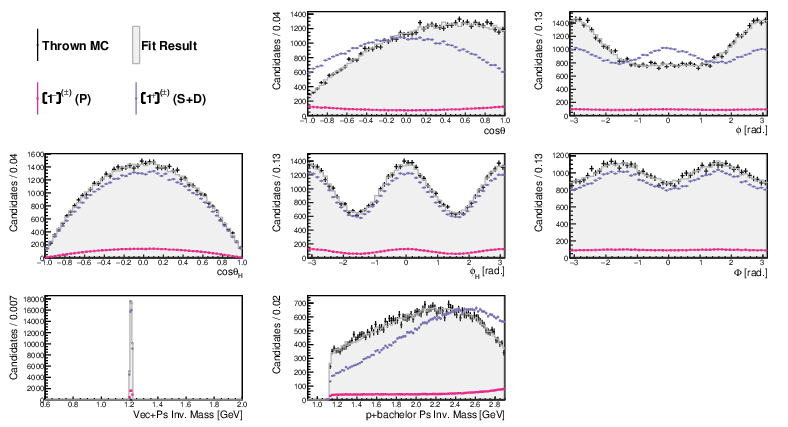

In [11]:
utils.display_pdf(f"{AMP_DIR}/fit.pdf")

Convert the fit output to csv files

In [12]:
%%bash

cd ${AMP_DIR}
python $WORKSPACE_DIR/src/neutralb1/batch/convert_to_csv.py\
    -i omegapi.fit -o  $STUDY_DIR/data/csv_files/amplitude_result.csv
python $WORKSPACE_DIR/src/neutralb1/batch/convert_to_csv.py\
    -i omegapi.fit -o $STUDY_DIR/data/csv_files/projected_moments.csv --moments

Checking if all input files exist...
Temp file created at /scratch/kscheuer/tmp5r3kmh5i
Running command: ['extract_fit_results', '/scratch/kscheuer/tmp5r3kmh5i', '/w/halld-scshelf2101/kscheuer/neutralb1/studies/input-output-tests/verify-moment/data/csv_files/amplitude_result.csv', '0']
Process completed successfully
Checking if all input files exist...
Temp file created at /scratch/kscheuer/tmpxky0ykqi
Running command: ['project_moments', '/scratch/kscheuer/tmpxky0ykqi', '/w/halld-scshelf2101/kscheuer/neutralb1/studies/input-output-tests/verify-moment/data/csv_files/projected_moments.csv']
Process completed successfully


#### Moments

Same process as the amplitude fits

In [13]:
%%bash
cat ${STUDY_DIR}/cfg_files/moments.cfg

# This cfg file is for fitting moments to an amplitude-generated dataset

# The H0_0000 moment is initialized to the number of events in the dataset, which is
# the only moment that is not randomized. All other moments are randomly initialized
# between +/- 1% of the number of events in the dataset. The set of moments used here
# corresponds to the moments of an S,P,D waveset.

###### SETUP ######
fit omegapi
sum omegapi vecPSMoment
normintfile omegapi omegapi.ni

reaction omegapi Beam Proton Pi01 Pi02 Pi+ Pi-
genmc omegapi ROOTDataReader anglesOmegaPiPhaseSpace.root
accmc omegapi ROOTDataReader anglesOmegaPiPhaseSpaceAcc.root
data omegapi ROOTDataReader data.root

# setup the parRange ability so that we can randomize the moments
keyword parRange 3 3

# Moment parameters
parameter H0_0000 50000
parameter H0_0010 0.0 
parameter H0_0011 0.0
parameter H0_0020 0.0
parameter H0_0021 0.0
parameter H0_0022 0.0
parameter H0_2000 0.0
parameter H0_2010 0.0
parameter H0_2011 0.0
parameter H0_2020

In [14]:
%%bash
cd $MOMENT_DIR
ln -sf ${STUDY_DIR}/data/root_files/data.root ./data.root
ln -sf ${STUDY_DIR}/data/root_files/anglesOmegaPiPhaseSpace.root
ln -sf ${STUDY_DIR}/data/root_files/anglesOmegaPiPhaseSpaceAcc.root

if [ -e "./omegapi.fit" ]; then
    echo "Moment results exist, skipping fitting."
else
    echo "Run 'fit -c ${STUDY_DIR}/cfg_files/moments.cfg -m 10000000 -r 50 > moment_fit.log' on an interactive GPU node to fit the data."
fi

Moment results exist, skipping fitting.


In [15]:
%%bash

cd ${MOMENT_DIR}
if [ -e ./vecps_plot.root ]; then
    echo "Plotter output already exists, skipping plotting."
else
    echo "Plotting results..."
    vecps_plotter ./omegapi.fit
    angle_plotter ./vecps_plot.root "Thrown MC" "" ${MOMENT_DIR} --gluex-style
fi

Plotter output already exists, skipping plotting.


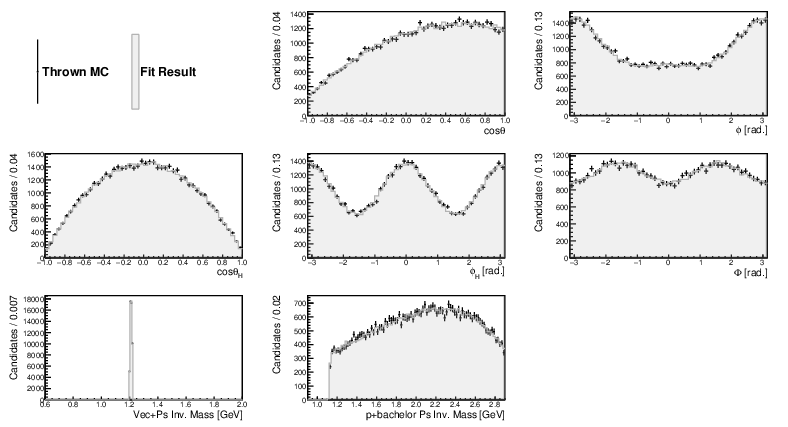

In [16]:
utils.display_pdf(f"{MOMENT_DIR}/fit.pdf")

In [17]:
%%bash

# The error for the following command is expected, the vecPSMoment amplitude cannot be parsed into coherent sums. This is fine because the 
# moments are stored as parameters, which do get extracted.
cd ${MOMENT_DIR}
python $WORKSPACE_DIR/src/neutralb1/batch/convert_to_csv.py\
    -i omegapi.fit -o  $STUDY_DIR/data/csv_files/moment_result.csv

Checking if all input files exist...
Temp file created at /scratch/kscheuer/tmpb0mdftes
Running command: ['extract_fit_results', '/scratch/kscheuer/tmpb0mdftes', '/w/halld-scshelf2101/kscheuer/neutralb1/studies/input-output-tests/verify-moment/data/csv_files/moment_result.csv', '0']
Error while running command:
Error parsing amplitude 'omegapi::vecPSMoment::vecPSMoment': Amplitude name 'vecPSMoment' does not match expected format. Expected format: [pm][0-9][pm][lnm0pqr][SPDFG...] where first character is reflectivity (p/m), second is total angular momentum (0-9), third is parity (p/m), fourth is m-projection (l/n/m/0/p/q/r), and remaining characters are orbital angular momentum (S/P/D/F/...).
Process completed successfully


## Analysis

In [18]:
# first load in our dataframes
data_df = pd.read_csv(f"{STUDY_DIR}/data/csv_files/data.csv")
fit_results_df = pd.read_csv(f"{STUDY_DIR}/data/csv_files/amplitude_result.csv")
truth_df = pd.read_csv(f"{STUDY_DIR}/data/csv_files/truth.csv")
projected_moments_df = pd.read_csv(f"{STUDY_DIR}/data/csv_files/projected_moments.csv")
fitted_moments_df = pd.read_csv(f"{STUDY_DIR}/data/csv_files/moment_result.csv")

### Checking Amplitude Results
We'll first want to make sure that our amplitude-based fits actually resolved to the values we generated with before we project them out

In [19]:
amplitude_results = ResultManager(fit_results_df, data_df, truth_df=truth_df)
amplitude_results.preprocess(linker_max_depth=2)

In [20]:
amp_columns = [l for sublist in utils.get_coherent_sums(amplitude_results.fit_df).values() for l in sublist]
phase_columns = list(set(utils.get_phase_differences(amplitude_results.fit_df).values()))

Print the percentage uncertainty of the results to make sure we don't have errors on the same order of magnitude as the result. Negative reflectivities are quite small so some of their values may be >50%

In [21]:
for col in amp_columns:
    rel_err = (amplitude_results.fit_df[f"{col}_err"] / amplitude_results.fit_df[col]).iloc[0] * 100
    if rel_err > 50:
        print(f"{col}: {rel_err}")
for col in phase_columns:    
    rel_err = (amplitude_results.fit_df[f"{col}_err"] / amplitude_results.fit_df[col]).iloc[0] * 100    
    print(f"{col}: {rel_err}")

m1m0P: 72.50445101575448
m1mmP: 537.8831172214938
m1mpP: 78.31996616180513
m1p0D: 103.04463714299779
m1p0S: 123.99905255076204
m1pmD: 86.68596361637435
m1pmS: 121.19455894476503
m1ppD: 87.76145972407654
m1ppS: 98.19738797215923
p1m0P: 50.6332758651334
p1mmP: 70.4990371280459
1mmP: 85.29321700666213
m1mP: 65.18095412771922
m1pS: 55.38075764206417
m1m: 65.18095412771922
p1p0D_p1ppD: 0.0440383448275862
m1ppS_m1mmP: -1.3273338473400156
m1p0S_m1ppD: -0.6393538630136987
p1ppS_p1ppD: 0.504708
p1ppS_p1m0P: 0.9577086419753087
p1pmS_p1m0P: 3.0838457583547556
p1ppD_p1mpP: 0.04699489971346705
m1m0P_m1mpP: 0.4093981016192071
p1p0S_p1m0P: -0.21635208913649023
p1pmD_p1mpP: -0.12240248447204968
m1pmS_m1p0S: 0.6781268115942028
m1pmD_m1p0D: -0.4013351111111111
p1pmS_p1mpP: 0.0756995996797438
p1pmD_p1p0D: -0.1518572614107884
m1p0S_m1p0D: -0.9376226075786769
p1p0S_p1ppD: 0.035378066666666666
m1pmS_m1m0P: -0.5452453146853147
m1p0D_m1mpP: -0.5710782103428239
p1pmS_p1pmD: -0.38078135469774216
p1ppS_p1mmP: -0

The standardized residuals for the amplitudes will let us know if any of the coherent sums are very far outside of the range captured by the error. They are not printed for the phases, as the errors are *very* underestimated for them and thus the standardized residuals are not trustworthy

In [22]:
for col in amp_columns:
    std_res = ((amplitude_results.fit_df[col] - amplitude_results.truth_df[col]) / amplitude_results.fit_df[f"{col}_err"]).iloc[0]
    if std_res > 3 or std_res < -3:
        print(f"{col}: {std_res}")

m1pD: -4.294216668555057
1pD: -3.2555882659441457


### Comparing Projected to Fitted Moments
We don't have "truth" moments to compare to, so we can move forward with checking how the moments projected from the amplitudes $H_{\text{projected}}$ compare to the moments obtained by fitting them to data with AmpTools $H_{\text{fitted}}$

In [23]:
# Find columns starting with "H" in both dataframes
proj_cols = [col for col in projected_moments_df.columns if col.startswith("H")]
fit_cols = [col for col in fitted_moments_df.columns if col.startswith("H") and not col.endswith("_err")]
print(proj_cols)
print(fit_cols)

['H0_0000_real', 'H0_0000_imag', 'H0_0010_real', 'H0_0010_imag', 'H0_0011_real', 'H0_0011_imag', 'H0_0020_real', 'H0_0020_imag', 'H0_0021_real', 'H0_0021_imag', 'H0_0022_real', 'H0_0022_imag', 'H0_2000_real', 'H0_2000_imag', 'H0_2010_real', 'H0_2010_imag', 'H0_2011_real', 'H0_2011_imag', 'H0_2020_real', 'H0_2020_imag', 'H0_2021_real', 'H0_2021_imag', 'H0_2022_real', 'H0_2022_imag', 'H0_2110_real', 'H0_2110_imag', 'H0_2111_real', 'H0_2111_imag', 'H0_2120_real', 'H0_2120_imag', 'H0_2121_real', 'H0_2121_imag', 'H0_2122_real', 'H0_2122_imag', 'H0_2220_real', 'H0_2220_imag', 'H0_2221_real', 'H0_2221_imag', 'H0_2222_real', 'H0_2222_imag', 'H1_0000_real', 'H1_0000_imag', 'H1_0010_real', 'H1_0010_imag', 'H1_0011_real', 'H1_0011_imag', 'H1_0020_real', 'H1_0020_imag', 'H1_0021_real', 'H1_0021_imag', 'H1_0022_real', 'H1_0022_imag', 'H1_2000_real', 'H1_2000_imag', 'H1_2010_real', 'H1_2010_imag', 'H1_2011_real', 'H1_2011_imag', 'H1_2020_real', 'H1_2020_imag', 'H1_2021_real', 'H1_2021_imag', 'H1_202

The projected moments are split into real and imaginary parts, whereas the fitted moments are forced to be one or the other. We expect the $H^0$ and $H^1$ moments to be purely real, and the $H^2$ moments to be purely imaginary. We'll make sure those values are close to zero.

In [24]:
H0_imag = [c for c in proj_cols if "H0" in c and "_imag" in c]
H1_imag = [c for c in proj_cols if "H1" in c and "_imag" in c]
H2_real = [c for c in proj_cols if "H2" in c and "_real" in c]

print(projected_moments_df[H0_imag + H1_imag + H2_real].max().max())

1.13687e-13


In [25]:
# Drop the "_imag" columns for H0 and H1, and the "_real" columns for H2
imag_cols_to_drop = [col for col in proj_cols if (col.startswith("H0") or col.startswith("H1")) and col.endswith("_imag")]
filtered_proj_moments_df = projected_moments_df.drop(columns=imag_cols_to_drop)
real_cols_to_drop = [col for col in proj_cols if col.startswith("H2") and col.endswith("_real")]
filtered_proj_moments_df = filtered_proj_moments_df.drop(columns=real_cols_to_drop)

# remove the real or imag suffix
filtered_proj_moments_df = filtered_proj_moments_df.rename(
    columns={col: col.replace("_real", "").replace("_imag", "") for col in filtered_proj_moments_df.columns}
)

In [26]:
# Ensure both dataframes have the same columns
print(set(filtered_proj_moments_df.columns) - set(fitted_moments_df.columns))

set()


In [27]:
# obtain the ratios between the projected and fitted moments
ratio_df = pd.DataFrame(index=filtered_proj_moments_df.index)
moment_columns = [c for c in filtered_proj_moments_df.columns if c.startswith("H")]
ratios = []
ratio_errs = []

for col in moment_columns:
    ratio = filtered_proj_moments_df[col] / fitted_moments_df[col]
    # for now we'll just use the MINUIT errors from the fitted moments
    ratio_err = ratio * np.sqrt(np.square(fitted_moments_df[f"{col}_err"] / fitted_moments_df[col]))
    ratios.append(ratio)
    ratio_errs.append(ratio_err)

ratio_errs_df = pd.DataFrame(ratio_errs).T
ratio_errs_df.columns = moment_columns

# add the ratio errors to the ratio dataframe as a new row
ratio_df = pd.concat([ratio_df, pd.DataFrame(ratios).T], axis=1)
ratio_df = pd.concat([ratio_df, ratio_errs_df], axis=0, ignore_index=True)

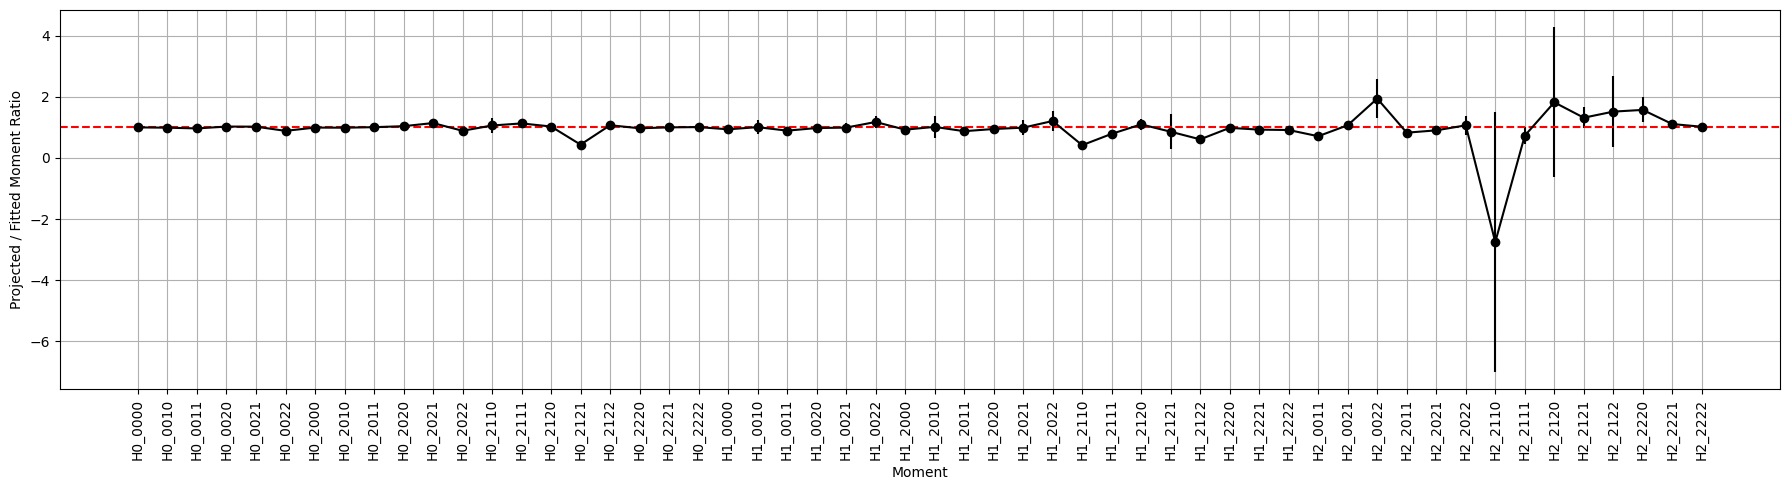

In [28]:
plt.figure(figsize=(18, 5))
plt.errorbar(x=ratio_df.columns, y=ratio_df.iloc[0], yerr=abs(ratio_df.iloc[1]), marker='o', color="black")
plt.axhline(y=1, color='red', linestyle='--', label='Expected Ratio = 1')
plt.xticks(rotation=90)
plt.ylabel("Projected / Fitted Moment Ratio")
plt.xlabel("Moment")
plt.grid(True)
plt.tight_layout()
plt.show()